# Deep Learning Practice: training Deep Neural Networks with Caffe
- slightly modified from examples/01-learning-lenet.ipynb
- 2016 April 15, Heo, Min-Oh

# 1. data preparation to train (MNIST)

In [2]:
!pwd

/opt/caffe


In [3]:
# Download data
#!data/mnist/get_mnist.sh

In [4]:
# Prepare data (building lmdb - lightweight database)
!examples/mnist/create_mnist.sh

Creating lmdb...
libdc1394 error: Failed to initialize libdc1394
libdc1394 error: Failed to initialize libdc1394
Done.


LMDB is a lightweigt key-value embedded data store developed by Symas for the OpenLDAP Project.
* http://symas.com/mdb/

In [5]:
# For processing general data: usage example link: http://stackoverflow.com/questions/31427094/guide-to-use-convert-imageset-cpp
!convert_imageset

#vi examples/cifar10/create_cifar10.sh 

libdc1394 error: Failed to initialize libdc1394
convert_imageset: Convert a set of images to the leveldb/lmdb
format used as input for Caffe.
Usage:
    convert_imageset [FLAGS] ROOTFOLDER/ LISTFILE DB_NAME
The ImageNet dataset for the training demo is at
    http://www.image-net.org/download-images


  Flags from /opt/caffe/tools/convert_imageset.cpp:
    -backend (The backend {lmdb, leveldb} for storing the result) type: string
      default: "lmdb"
    -check_size (When this option is on, check that all the datum have the same
      size) type: bool default: false
    -encode_type (Optional: What type should we encode the image as
      ('png','jpg',...).) type: string default: ""
    -encoded (When this option is on, the encoded image will be save in datum)
      type: bool default: false
    -gray (When this option is on, treat images as grayscale ones) type: bool
      default: false
    -resize_height (Height images are resized to) type: int32 default: 0
    -resize_width (Width

## 2. edit prototxt files with python
* .prototxt: 
    * the net prototxt: defining the architecture (and pointing to train/test data)
    * the solver prototxt: defining the learning parameters with google protocol buffer
* .caffemodel: binary file having neural network parameters

In [6]:
import caffe
from caffe import layers as L, params as P

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [7]:
def lenet(lmdb, batch_size):
    # a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()

    ### data input setting
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    ### 2 convolutional layer + 2 fully-connected layer
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

* We can write prototxt files with caffe.NetSpec()

In [8]:
import os 
os.chdir('examples')
!pwd

/opt/caffe/examples


In [9]:
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

In [10]:
!cat mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

In [11]:
!cat mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


In [12]:
!pwd

/opt/caffe/examples


## 3. loading and checking the solver

In [13]:
# CPU or GPU?
# caffe.set_device(0)
caffe.set_mode_cpu()

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

In [14]:
# each output is (batch size, number of channels, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]   

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

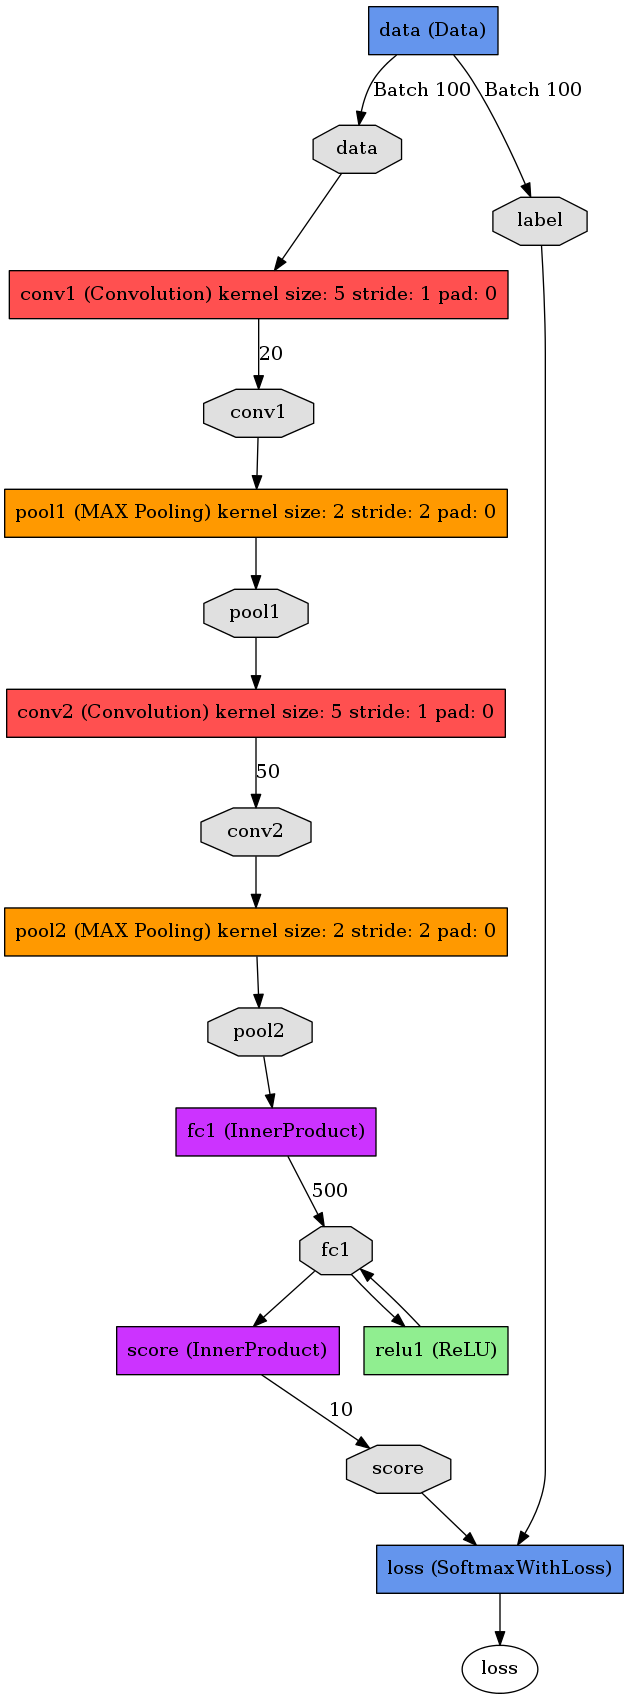

In [15]:
from google.protobuf import text_format
from caffe.draw import get_pydot_graph
from caffe.proto import caffe_pb2
from IPython.display import display, Image 

_net = caffe_pb2.NetParameter()
f = open("mnist/lenet_auto_test.prototxt")
text_format.Merge(f.read(), _net)
display(Image(get_pydot_graph(_net,"TB").create_png()))

In [16]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [25]:
solver.net.forward()  # train net

{'loss': array(2.338440418243408, dtype=float32)}

In [26]:
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.348280429840088, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


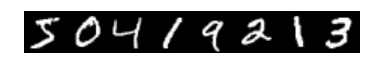

In [19]:
from pylab import *
%matplotlib inline

# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


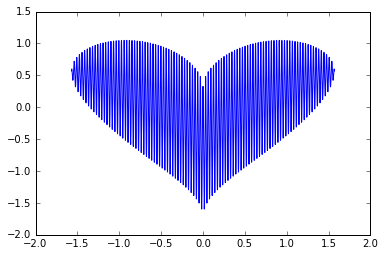

In [27]:
from pylab import *
x = linspace(-1.6, 1.6, 10000)
f = lambda x: (sqrt(cos(x)) * cos(200 * x) + sqrt(abs(x)) - 0.7) * \
pow((4 - x * x), 0.01)
plot(x, map(f, x))

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


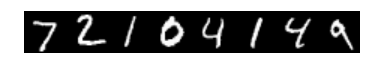

In [18]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

## 4. one step learning

In [19]:
solver.step(1) # SGD by Caffe

(-0.5, 24.5, 19.5, -0.5)

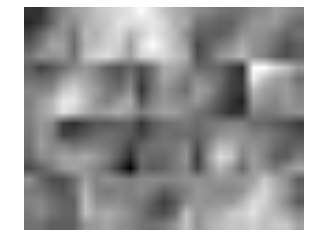

In [20]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

In [21]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 1min 14s, sys: 40 ms, total: 1min 14s
Wall time: 1min 14s


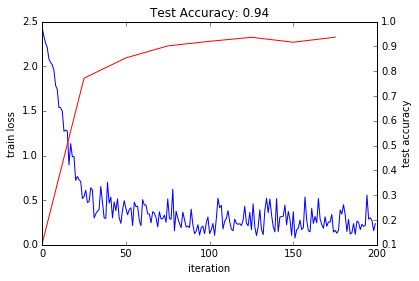

In [22]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

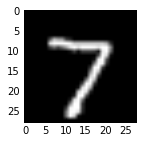

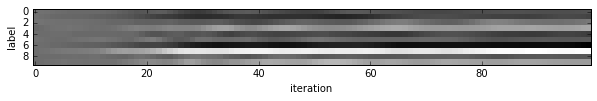

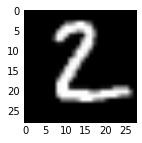

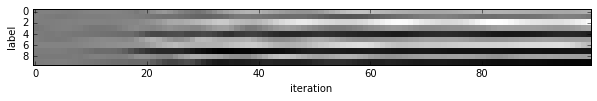

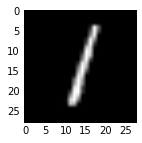

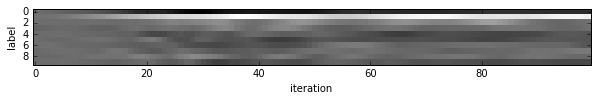

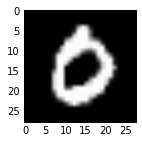

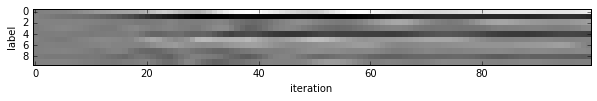

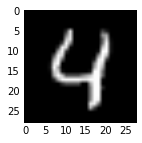

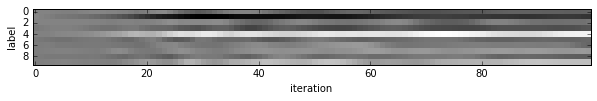

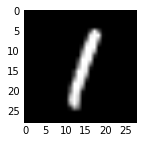

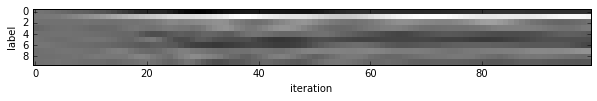

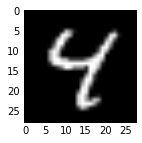

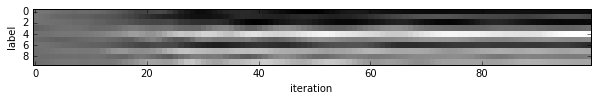

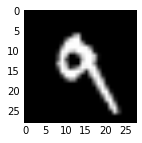

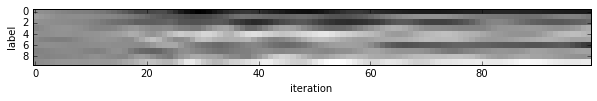

In [23]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:100, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')